In [1]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms
import torchaudio
import pandas as pd
import torch
import torch.nn as nn

In [2]:
import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Apple device detected
Activating Apple Silicon GPU
mps


In [3]:
# To use 3 channel Resnet
class MonoToColor(nn.Module):
    def __init__(self, num_channels=3):
        super(MonoToColor, self).__init__()
        self.num_channels = num_channels

    def forward(self, tensor):
        return tensor.repeat(self.num_channels, 1, 1)

In [4]:
# Dataset 클래스 정의
import os
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        
        # Directly assign class IDs without filtering on selected labels
        self.annotations['classID'] = self.annotations['class'].astype('category').cat.codes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, torch.tensor(label, dtype=torch.long)

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.target_sample_rate:
            signal = signal[:, :self.target_sample_rate]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.target_sample_rate:
            num_missing_samples = self.target_sample_rate - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = self.annotations.iloc[index, 5]
        file_name = self.annotations.iloc[index, 0]
        #audio_sample_path = os.path.join(self.audio_dir, fold, file_name)
        audio_sample_path = os.path.join("../../../../../검은 상자/@CODE",self.audio_dir, fold, file_name)
        return audio_sample_path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [5]:
# 데이터셋 및 데이터 로더 설정
import pandas as pd

# Load the dataset
ANNOTATIONS_FILE = '/Volumes/검은 상자/@CODE/dataset2/data2.csv'
temp_csv = pd.read_csv('/Volumes/검은 상자/@CODE/dataset2/data2.csv')
temp_csv.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,children_cut_0000.wav,540970,259.733605,261.733605,1,children,0,children
1,children_cut_0001.wav,548447,3183.482744,3185.482744,1,children,0,children
2,children_cut_0002.wav,883691,237.423311,239.423311,1,children,0,children
3,children_cut_0003.wav,661176,1907.488526,1909.488526,1,children,0,children
4,children_cut_0004.wav,969140,3735.553537,3737.553537,1,children,0,children
5,children_cut_0005.wav,742221,684.140272,686.140272,1,children,0,children
6,children_cut_0006.wav,776059,2565.087755,2567.087755,1,children,0,children
7,children_cut_0007.wav,265473,3600.593900,3602.593900,1,children,0,children
8,children_cut_0008.wav,582832,1581.066780,1583.066780,1,children,0,children
9,children_cut_0009.wav,891737,1144.900794,1146.900794,1,children,0,children


In [6]:
import pandas as pd

# Assuming you have the ANNOTATIONS_FILE dataframe
# You can use the value_counts() function on the 'class' column
label_counts = temp_csv['class'].value_counts()

# Display the counts of files for each label in a tabular format
print(label_counts)

children        1000
nothing2        1000
drilling        1000
engine          1000
siren           1000
gunshot         1000
aircon          1000
jackhammer      1000
carhorn         1000
glass           1000
nock            1000
street_music    1000
dog_bark        1000
nothing1        1000
Name: class, dtype: int64


In [7]:
random = 1 # 1== random,  0 == fix seed

if random == 0:
    import random
    import numpy as np

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [8]:
AUDIO_DIR = 'dataset2'

In [9]:
SAMPLE_RATE = 22050
BATCH_SIZE = 4
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False

In [10]:
class MinMaxNormalize(nn.Module):
    def __init__(self, min_val=None, max_val=None):
        super(MinMaxNormalize, self).__init__()
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, tensor):
        if self.min_val is None or self.max_val is None:
            min_val = torch.min(tensor)
            max_val = torch.max(tensor)
        else:
            min_val = self.min_val
            max_val = self.max_val
        
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
        return normalized_tensor

In [11]:
transformation = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=40),# higher the better but more complex. For talking we use 128, for sound effect, about 40.
    torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80),
    MinMaxNormalize(),
    MonoToColor()
])

In [12]:
usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE)

In [13]:
# 데이터셋 분리
dataset_size = len(usd)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(usd, [train_size, val_size, test_size])

# 데이터 로더 생성
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)


In [14]:
ANNOTATIONS_FILE

'/Volumes/검은 상자/@CODE/dataset2/data2.csv'

In [15]:
usd

In [16]:
num_labels = len(usd.annotations['classID'].unique())
num_labels

14

In [17]:
# ResNet18 모델 설정
model = resnet18(pretrained=False)
# Change the output neurons of the model
model.fc = nn.Linear(512,num_labels) 
# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
model = model.to(device)

/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# 학습률 스케줄러 설정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train func 2 (more normal)

In [20]:
from tqdm import tqdm

def train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    global best_acc
    global train_loss_list, val_loss_list, train_acc_list, val_acc_list
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    best_acc = 0.0
    best_model_counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss_train = 0.0
        running_corrects_train = 0

        for inputs, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss_train += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss_train = running_loss_train / dataset_sizes['train']
        epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        # Append to the train lists
        train_loss_list.append(epoch_loss_train)
        train_acc_list.append(epoch_acc_train.item())

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss_val = 0.0
        running_corrects_val = 0

        for inputs, labels in tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / dataset_sizes['val']
        epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        # Append to the validation lists
        val_loss_list.append(epoch_loss_val)
        val_acc_list.append(epoch_acc_val.item())

        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_counter += 1
            formatted_counter = str(best_model_counter).zfill(3)
            model_save_path = os.path.join("models", f"Batch4-1k_{formatted_counter}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f'Best model saved at {model_save_path}')

    print('Best Validation Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# This is the updated function
train_model2

<function __main__.train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs)>

In [22]:
import copy
nb_epochs = 10
# 모델 훈련 시작
dataloaders = {"train": train_loader, "val": val_loader}
# define dataset_sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

best_model = train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs=nb_epochs)

Epoch 1/10
----------


100%|██████████| 2800/2800 [06:44<00:00,  6.92it/s]


Train Loss: 0.5010 Acc: 0.8288


100%|██████████| 1400/1400 [00:47<00:00, 29.51it/s]


Validation Loss: 0.4358 Acc: 0.8536
Best model saved at models/Batch4-1k_001.pth
Epoch 2/10
----------


100%|██████████| 2800/2800 [06:44<00:00,  6.93it/s]


Train Loss: 0.4021 Acc: 0.8602


100%|██████████| 1400/1400 [00:47<00:00, 29.46it/s]


Validation Loss: 0.3932 Acc: 0.8993
Best model saved at models/Batch4-1k_002.pth
Epoch 3/10
----------


100%|██████████| 2800/2800 [06:37<00:00,  7.05it/s]


Train Loss: 0.3328 Acc: 0.8841


100%|██████████| 1400/1400 [00:46<00:00, 29.95it/s]


Validation Loss: 0.3036 Acc: 0.8964
Epoch 4/10
----------


100%|██████████| 2800/2800 [06:37<00:00,  7.04it/s]


Train Loss: 0.2926 Acc: 0.8996


100%|██████████| 1400/1400 [00:47<00:00, 29.48it/s]


Validation Loss: 0.3550 Acc: 0.8921
Epoch 5/10
----------


100%|██████████| 2800/2800 [06:37<00:00,  7.04it/s]


Train Loss: 0.2435 Acc: 0.9147


100%|██████████| 1400/1400 [00:47<00:00, 29.30it/s]


Validation Loss: 0.3362 Acc: 0.8921
Epoch 6/10
----------


100%|██████████| 2800/2800 [06:38<00:00,  7.02it/s]


Train Loss: 0.1378 Acc: 0.9513


100%|██████████| 1400/1400 [00:47<00:00, 29.48it/s]


Validation Loss: 0.1457 Acc: 0.9507
Best model saved at models/Batch4-1k_003.pth
Epoch 7/10
----------


100%|██████████| 2800/2800 [06:39<00:00,  7.00it/s]


Train Loss: 0.1082 Acc: 0.9622


100%|██████████| 1400/1400 [00:47<00:00, 29.54it/s]


Validation Loss: 0.1453 Acc: 0.9500
Epoch 8/10
----------


100%|██████████| 2800/2800 [06:38<00:00,  7.03it/s]


Train Loss: 0.0943 Acc: 0.9671


100%|██████████| 1400/1400 [00:47<00:00, 29.45it/s]


Validation Loss: 0.1427 Acc: 0.9529
Best model saved at models/Batch4-1k_004.pth
Epoch 9/10
----------


100%|██████████| 2800/2800 [06:50<00:00,  6.82it/s]


Train Loss: 0.0801 Acc: 0.9711


100%|██████████| 1400/1400 [00:48<00:00, 28.81it/s]


Validation Loss: 0.1424 Acc: 0.9514
Epoch 10/10
----------


 75%|███████▌  | 2100/2800 [05:20<01:46,  6.54it/s]


RuntimeError: Failed to load audio from ../../../../../검은 상자/@CODE/dataset2/street_music/street_music_cut_0799.wav

In [23]:
train_acc_list = torch.tensor(train_acc_list).detach().cpu()

In [24]:
val_acc_list = torch.tensor(val_acc_list).detach().cpu()

ValueError: x and y must have same first dimension, but have shapes (10,) and (9,)

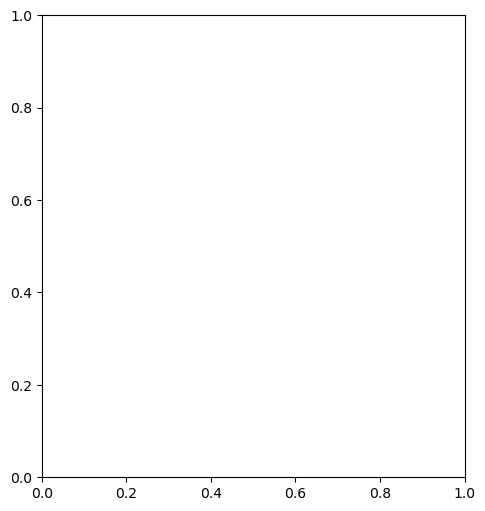

In [25]:
# Plot training and validation loss and accuracy
# Move tensors to CPU
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nb_epochs + 1), train_loss_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_loss_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, nb_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 모델 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total}%')


In [ ]:
# 훈련 및 평가
test_model(best_model, test_loader, device)

100%|██████████| 1400/1400 [00:49<00:00, 28.19it/s]

Accuracy of the model on test images: 26.071428571428573%
